In [ ]:
from importlib import reload
reload(iup)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Part 1 : Data Import**

## **Step 1.1 : Get the Utterance Files** 

In [2]:
!pip install tftb

     |████████████████████████████████| 61kB 1.9MB/s 


In [3]:
import sys
sys.path.append('/content/IEMOCAPFeatures_Utility.py')
import IEMOCAPFeatures_Utility as iup

In [ ]:
import IEMOCAPFeatures_Utility as iup
import pandas as pd
Sessions = [1,2,3,4,5]
Utterances = pd.DataFrame()
for S in Sessions:
  Utterances = pd.concat([Utterances,pd.read_pickle('/content/drive/My Drive/IIIT  College files/4th Year - 7th Semester (Internship)/IEMOCAP_DB/Features and Pickles/UtteranceInfo_S' + str(S) + '.pkl')])  
Utterances.head()

In [ ]:
iup.GetSummary(Utterances)

In [ ]:
iup.GetSummary(Labels)

## **Step 1.2 : Import Feature Data**

In [4]:
import pandas as pd
Sessions = [1,2,3,4,5]
DataSet = pd.DataFrame()
Root = '/content/drive/My Drive/IIIT  College files/4th Year - 7th Semester (Internship)/IEMOCAP_DB/Features and Pickles'
for S in Sessions:
  DataSet = pd.concat([DataSet,pd.read_pickle(Root + '/FS_S' + str(S) + '.pkl')])
#FeatureSet = FeatureSet.sample(200)
DataSet.head()

,Batch,TURN_NAME,V,BatchLengths
0,"[[-0.00023150803770010604, 0.00030262782423969...",Ses01F_impro01_F000,2.5,97
1,"[[1.4191344989205311e-05, -1.8921462174550534e...",Ses01F_impro01_F001,2.5,69
2,"[[0.00011663194451581222, -0.00014325878166155...",Ses01F_impro01_F002,2.5,156
3,"[[-0.0002869330655657432, 0.000352191164916809...",Ses01F_impro01_F003,2.5,74
4,"[[-0.0001057988882744807, 5.182847164486578e-0...",Ses01F_impro01_F004,2.5,170


In [5]:
iup.GetSummary(DataSet)

,Valence,Count
0,1.0000,126.0
1,1.3333,18.0
2,1.5000,925.0
3,1.6667,79.0
4,2.0000,2075.0
5,2.3333,198.0
6,2.5000,1935.0
7,2.6667,170.0
8,3.0000,1607.0
9,3.3333,80.0


In [6]:
NT = 2.4
PT = 3.9
Labels = {'Negative':0,'Neutral':1,'Positive':2}
DataSet['V'] = DataSet['V'].apply(lambda x : Labels['Negative'] if x < NT \
                                        else Labels['Positive'] if x > PT else Labels['Neutral'])

In [9]:
iup.GetSummary(DataSet)

,Valence,Count
0,0.0,1947.0
1,1.0,1947.0
2,2.0,1947.0


In [7]:
Temp = pd.DataFrame()
for V in Labels.values():
  Temp = pd.concat([Temp, DataSet[DataSet['V'] == V].sample(int(min(iup.GetSummary(DataSet)['Count'])))],ignore_index=True)
DataSet = Temp

In [19]:
from sklearn.model_selection import train_test_split
_,FeatureSet = train_test_split(DataSet,stratify = DataSet.V,test_size = 100)

# **Part 2 : Model Building**

## **Step 2.1 : Split in Train and Test Data**

In [26]:
TrainDataSet, DevDataSet = train_test_split(FeatureSet, test_size = 0.2\
                                            ,stratify = FeatureSet.V)

In [27]:
TrainSummary = iup.GetSummary(TrainDataSet)
DevSummary = iup.GetSummary(DevDataSet)
n_TrainSamples_BefAug = TrainSummary['Count'].to_numpy().tolist()
n_DevSamples_BefAug = DevSummary['Count'].to_numpy().tolist()

In [28]:
import numpy as np
from tqdm import tqdm
BatLenTHR = 1
TrainX, TrainY, TrainNames = iup.AugmentData(TrainDataSet,BatLenTHR)
DevX, DevY, DevNames = iup.AugmentData(DevDataSet,BatLenTHR)
n_TrainSamples_AftAug = iup.GetSummary(pd.DataFrame(TrainY,columns=['V']))['Count'].to_numpy().tolist()
n_Devamples_AftAug =  iup.GetSummary(pd.DataFrame(DevY,columns=['V']))['Count'].to_numpy().tolist()

100%|██████████| 20/20 [00:00<00:00, 617.04it/s]


In [29]:
TrainSilent = np.array(list(map(lambda x : True if x[:,-2] <= 0.12 else False,TrainX)))
DevSilent = np.array(list(map(lambda x : True if x[:,-2] <= 0.12 else False,DevX)))

In [30]:
TrainX = np.array(list(map(lambda x : x[0],TrainX)))
DevX = np.array(list(map(lambda x : x[0],DevX)))

In [31]:
print('Training Data : ',TrainX.shape, 'Labels :', TrainY.shape)
print('Development Data : ',DevX.shape, 'Labels :', DevY.shape)

Training Data :  (19106, 12) Labels : (19106,)
Development Data :  (4326, 12) Labels : (4326,)


## **Step 2.2 : Model Training on Train Set and observing the thresholds**

In [36]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
model = BaggingRegressor(base_estimator = RandomForestRegressor(n_jobs = -1),n_estimators = 50, verbose=1, n_jobs = -1)
model.fit(TrainX[~TrainSilent],TrainY[~TrainSilent])

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.9min finished


BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                 

# **Part 3 : Post-processing**

## **Step 3.1 : Statistical Guess of the Thresholds**


In [37]:
TrainDataResults = pd.DataFrame([])
TrainDataResults['SampleName'] = TrainNames[~TrainSilent]
TrainDataResults['Actual'] = TrainY[~TrainSilent]
TrainDataResults['Predicted'] = model.predict(TrainX[~TrainSilent])
TrainDataResults = TrainDataResults.sort_values('Actual')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   13.2s finished


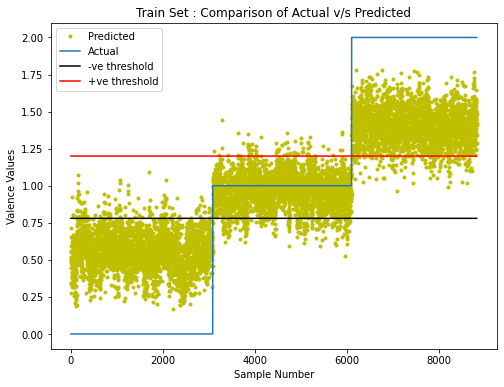

In [47]:
PT = 1.20
NT = 0.78
iup.plotResults(TrainDataResults,NT,PT,'Train','BGRFTrain')

In [48]:
TrainDataResults['Thresholded'] = TrainDataResults['Predicted'].apply(lambda x : Labels['Negative'] if x < NT\
                                                    else Labels['Positive'] if x > PT else Labels['Neutral'])

Labels are : {'Negative': 0, 'Neutral': 1, 'Positive': 2}
UAR for Train Set  =  0.9370431213132063
Classwise Accuracy for Train Set ['Negative', 'Neutral', 'Positive'] [0.95556276 0.9055666  0.95      ]


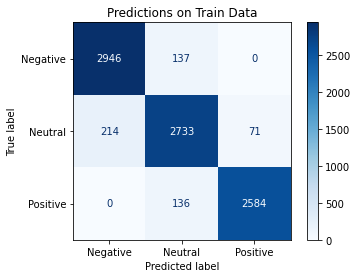

In [49]:
_,_ = iup.GetCMandMetrics(TrainDataResults,'Train','TrainCM',Labels)

## **Step 3.2 : Run Model on Validation and apply Thresholds on them**

In [50]:
DevDataResults = pd.DataFrame([])
DevDataResults['SampleName'] = DevNames[~DevSilent]
DevDataResults['Actual'] = DevY[~DevSilent]
DevDataResults['Predicted'] = model.predict(DevX[~DevSilent])
DevDataResults = DevDataResults.sort_values('Actual')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    9.8s finished


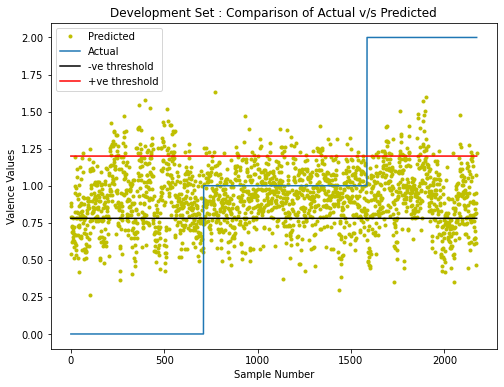

In [51]:
iup.plotResults(DevDataResults,NT,PT,'Development','BGRFDev')

Labels are : {'Negative': 0, 'Neutral': 1, 'Positive': 2}
UAR for Development Set  =  0.3881626721011893
Classwise Accuracy for Development Set ['Negative', 'Neutral', 'Positive'] [0.31786217 0.74628571 0.10034014]


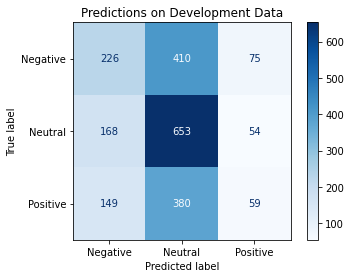

In [52]:
DevDataResults['Thresholded'] = DevDataResults['Predicted'].apply(lambda x : Labels['Negative'] if x < NT\
                                                    else Labels['Positive'] if x > PT else Labels['Neutral'])
_,_ = iup.GetCMandMetrics(DevDataResults,'Development','BGRFDevCM',Labels)

# **Part 4 : Obtain Predictions on File Level**

# **Part 5 : Save the Experiment Log**